In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import lsst.sims.maf.utils as utils
from astropy.table import Table, Column
import json
from scipy.optimize import curve_fit
from astropy.io import ascii

In [2]:
# Establish where the LSST simulations data is coming from, and where output data will go
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [3]:
# Establish points of evaluation, how to evaluate (slice) them, and any constraints
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
# slicer = slicers.UserPointsSlicer(ra,dec)
slicer = slicers.UserPointsSlicer((349.4, 0.00, 53.0, 34.4, 150.4), (-63.3, -45.5, -27.4, -5.1, 2.8))
sql = ''
# Run the metric, slicer, and constraint together as a "bundle"
bundle = metricBundles.MetricBundle(metric,slicer,sql)
# Group the previous bundle with the data from the LSST simulations
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
%time bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 34.5 s, sys: 2.78 s, total: 37.3 s
Wall time: 59.2 s


In [4]:
def survey_setup(bundle):
    opsimlist = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for key in ['fieldRA', 'fieldDec', 
                                                                  'expMJD', 'filter', 'fiveSigmaDepth']}
        opsim = Table(bdict)
        opsim.sort(['expMJD'])
        opsim = opsim['fieldRA', 'fieldDec', 'expMJD','filter','fiveSigmaDepth']
    
        # Only do the following if you need to narrow simulation filters to those matching your lightcurve data
        opsim = opsim[opsim['filter'] != 'u']
        opsim = opsim[opsim['filter'] != 'y']
        opsimlist.append(opsim)
    return opsimlist

In [5]:
def tde_model(asciifile):
    model = np.genfromtxt(asciifile, dtype=[('mjd',np.float), ('filter','S1'), ('mag',np.float)])
    model = Table(model)
    model = model[model['mjd'] <= 200]
    filter_match = np.where(model['filter'] == 'g')
    peakmag = model['mag'][filter_match].min()
    model['mag'] = model['mag'] - peakmag
    filter_match = np.where(model['filter'] == 'g')
    peakmag_row = model['mag'][filter_match].argmin()
    peakday = model['mjd'][filter_match][peakmag_row]
    model['mjd'] = model['mjd'] - peakday
    model = model['mjd', 'filter', 'mag']
    return model

In [6]:
def tde_raw(jsonfile):
    # Open and load json file with TDE values
    tde_data = open(jsonfile)
    tde = json.load(tde_data)
    z = 0.1696
    # Set up dictionary for json data
    data = {'mjd': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
    # Use for loop to call to values within the json file
    for entry in tde['PS1-10jh']['photometry']:
        # Ignore instances in which 'band' and 'magnitude' have no data
        if 'band' in entry and 'magnitude' in entry:
            data['mjd'].append(float(entry['time']))
            data['filter'].append(entry['band'])
            data['mag'].append(float(entry['magnitude']))
            # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
            if 'upperlimit' in entry:
                data['upperlimit'].append(entry['upperlimit'])
            else:
                data['upperlimit'].append(False)
            # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
            if 'e_magnitude' in entry:
                data['magerror'].append(float(entry['e_magnitude']))
            else:
                data['magerror'].append(99)
    
    # Table the now-full dictionary of TDE data
    tde_table = Table(data)
    
    # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
    # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
    tde_table = tde_table[tde_table['upperlimit'] == False]
    tde_table['mjd'] = tde_table['mjd'] - tde_table['mjd'].min()
    tde_table['rfday'] = tde_table['mjd']/(1+z)
    tde_table = tde_table[tde_table['magerror'] <= 0.3]
    tde_table = tde_table[tde_table['filter'] != 'NUV']
    tde_table = tde_table[tde_table['filter'] != 'F225W']
    tde_table = tde_table[tde_table['rfday'] <= 150]
    return tde_table

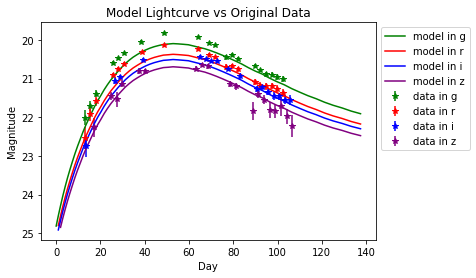

In [81]:
model = tde_model('G14_model_PS1-10jh.ascii')
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
tde_table = tde_raw('PS1-10jh.json')
for f in ['g', 'r', 'i', 'z']:
    filter_match = np.where(model['filter'] == f)
    filter_match2 = np.where(tde_table['filter'] == f)
    plt.plot(model['mjd'][filter_match], model['mag'][filter_match], 
             color=colors[f], label=('model in %s' %f))
    plt.errorbar(tde_table['rfday'][filter_match2], tde_table['mag'][filter_match2], 
                 yerr=tde_table['magerror'][filter_match2], color=colors[f], fmt='*', label=('data in %s' %f))
plt.ylim(plt.ylim()[::-1])
plt.title('Model Lightcurve vs Original Data')
plt.xlabel('Day')
plt.ylabel('Magnitude')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [6]:
def find_peak(model):
    peak = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(model['filter'] == f)
        peakmag = model['mag'][filter_match].min()
        peakmag_row = model['mag'][filter_match].argmin()
        peakday = model['mjd'][filter_match][peakmag_row]
        peak[f] = {'peakday': peakday, 'peakmag': peakmag}
    return peak

In [7]:
def shift_peak(model, outputmag, outputtime):
    """
    Shifts peak magnitude and time of peak of a template lightcurve.
    """
    adjusted_tde = model.copy()
    adjusted_tde['mag'] += outputmag
    adjusted_tde['mjd'] += outputtime
    return adjusted_tde

In [8]:
def interpolate_lc(tde_table, time_range):
    lc = {}
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(tde_table['filter'] == f)
        lc[f] = np.interp(time_range, tde_table['mjd'][filter_match], tde_table['mag'][filter_match],
                          left=99, right=99)
    return lc

In [9]:
def resample_lc(opsim, shifted_tde_table):
    time_range = opsim['expMJD']
    lc = interpolate_lc(shifted_tde_table, time_range)
    tde_lc = Table(lc)
    tde_lc['mjd'] = time_range
    tde_lc = tde_lc['mjd', 'g', 'r', 'i', 'z']
    return tde_lc

In [10]:
def update_opsim(opsim, tde_lc):    
    opsim['magnitude'] = 0.0
    for row in range(len(opsim)):
        f = opsim['filter'][row]
        opsim['magnitude'][row] = tde_lc[f][row]
    return opsim

In [11]:
def find_error(opsim):
    # Find error based off of 5sigDepth, and add it to the table with magnitudes
    snr = 5*(10**((-0.4)*(opsim['magnitude'] - opsim['fiveSigmaDepth'])))
    tde_err = 2.5/(snr*np.log(10))
    opsim['tde_err'] = tde_err
    opsim = opsim[opsim['tde_err'] < 0.3]
    return opsim

In [12]:
def add_noise(opsim):
    opsim['magnitude'] = np.random.normal(opsim['magnitude'], opsim['tde_err'])
    return opsim

In [13]:
def interpolate_lc_alltimes(shifted_tde_fmatch):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    lc = interpolate_lc(shifted_tde_fmatch, time_range)
    lc = Table(lc)
    lc['mjd'] = time_range
    tde_lc_all = Table(names = ('mjd', 'filter', 'mag'), dtype = ('float', 'str', 'float'))
    for day in lc['mjd']:
        for f in ['g', 'r', 'i', 'z']:
            row = np.where(lc['mjd'] == day)
            tde_lc_all.add_row([day, f, lc[f][row]])
    return shifted_tde_all

In [14]:
def poly(x, a, b, c, d, e, f, g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

def curvefit_full_lightcurve(shifted_tde_all):
    for f in ['g', 'r', 'i', 'z']:
        filter_match = np.where(shifted_tde_all['filter'] == f)
        popt, pcov = curve_fit(poly, shifted_tde_all['mjd'][filter_match],
                               shifted_tde_all['mag'][filter_match], )
        plt.figure()
        plt.plot(shifted_tde_all['mjd'][filter_match], shifted_tde_all['mag'][filter_match], 
                 color = colors[f], label = '%s raw lightcurve' % f)
        plt.plot(shifted_tde_all['mjd'][filter_match], poly(shifted_tde_all['mjd'][filter_match], *popt), 
                 'black', label = '%s curvefit lightcurve' % f)
        plt.ylim(plt.ylim()[::-1])
        plt.title('TDE \'Curvefit\' and TDE interpolated over all times')
        plt.xlabel('Day')
        plt.ylabel('Magnitude')
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [15]:
def make_template_per_filter(f):
    def make_template(time, time_shift, mag_shift):
        new_model = model.copy()
        new_model['mjd'] += time_shift
        new_model['mag'] += mag_shift
        template = interpolate_lc(new_model, time)
        return template[f]
    return make_template

def poly2(x, a, b, c, x0):
    return a*(x-x0)**2 + b*(x-x0) + c

def find_resampled_peak(opsim_fmatch):
    opsim_peakmag = opsim_fmatch['magnitude'].min()
    opsim_peakday_row = opsim_fmatch['magnitude'].argmin()
    opsim_peakday = opsim_fmatch['expMJD'][opsim_peakday_row]
    return [opsim_peakday, opsim_peakmag]

def find_a(opsim_fmatch):
    time = opsim_fmatch.copy()
    time = time[time['expMJD'] <= (75 + shifted_tde_table['mjd'].min())]
    opsim_peakday, opsim_peakmag = find_resampled_peak(time)
    first_day = time['expMJD'].min()
    first_mag_row = time['expMJD'].argmin()
    first_mag = time['magnitude'][first_mag_row]
    last_day = time['expMJD'].max()
    last_mag_row = time['expMJD'].argmax()
    last_mag = time['magnitude'][last_mag_row]
    if first_day != opsim_peakday:
        A = (first_mag - opsim_peakmag)/((first_day - opsim_peakday)**2)
    else:
        A = (last_mag - opsim_peakmag)/((last_day - opsim_peakday)**2)
    return A

def curvefit_template(opsim_fmatch, f):
    popt1, pcov1 = curve_fit(make_template_per_filter(f), opsim_fmatch['expMJD'], opsim_fmatch['magnitude'], 
                             p0 = find_resampled_peak(opsim_fmatch), sigma = opsim_fmatch['tde_err'])
    return [popt1, pcov1]

def curvefit_poly(opsim_fmatch, shifted_tde_table, f):
    opsim_peakday, opsim_peakmag = find_resampled_peak(opsim_fmatch)
    A = find_a(opsim_fmatch)
    params = [A, 0, opsim_peakmag, opsim_peakday]
    time = opsim_fmatch.copy()
    time = time[time['expMJD'] <= (75 + shifted_tde_table['mjd'].min())]
    popt2, pcov2 = curve_fit(poly2, time['expMJD'], time['magnitude'], 
                             p0 = params, sigma = time['tde_err'])
    return [popt2, pcov2]

def plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    with PdfPages('multipage_pdf.pdf') as pdf:
        plt.figure()
        plt.errorbar(opsim_fmatch['expMJD'], opsim_fmatch['magnitude'], 
                     yerr = opsim_fmatch['tde_err'], color = colors[f],
                     fmt = '*', label = '%s resampled lightcurve' % f)
        plt.plot(time_range, make_template_per_filter(f)(time_range, *popt1), 
                 'black', label = '%s curvefit resampled lightcurve' %f)
        plt.plot(time_range, poly2(time_range, *popt2), 
                 'teal', label = '%s curvefit resampled lightcurve' %f)
        plt.plot(shifted_tde_fmatch['mjd'], shifted_tde_fmatch['mag'], 
                 color = colors[f], label = '%s raw lightcurve' % f)
        plt.ylim((plt.ylim()[0], 26)[::-1])
        plt.title('Original, resample, and curvefit in %s at ra=%f and dec=%f, peakmag=%d and peaktime=%d'
                  % (f, ra, dec, testpeakmag, testpeakday))
        plt.xlabel('Day')
        plt.ylabel('Magnitude')
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [16]:
def find_template_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peak_mag = shifted_tde_fmatch['mag'].min()
    curvefit_peak_mag = make_template_per_filter(f)(time_range, *popt).min()
    peak_diff_mag = curvefit_peak_mag - original_peak_mag
    return peak_diff_mag

In [17]:
def find_template_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peakday_row = shifted_tde_fmatch['mag'].argmin()
    original_peakday = shifted_tde_fmatch['mjd'][original_peakday_row]
    curvefit_peakday = make_template_per_filter(f)(time_range, *popt).argmin() + time_range.min()
    peak_diff_day = curvefit_peakday - original_peakday
    return peak_diff_day

In [18]:
def find_poly_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peak_mag = shifted_tde_fmatch['mag'].min()
    curvefit_peak_mag = poly2(time_range, *popt).min()
    peak_diff_mag = curvefit_peak_mag - original_peak_mag
    return peak_diff_mag

In [19]:
def find_poly_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt):
    time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
    original_peakday_row = shifted_tde_fmatch['mag'].argmin()
    original_peakday = shifted_tde_fmatch['mjd'][original_peakday_row]
    curvefit_peakday = poly2(time_range, *popt).argmin() + time_range.min()
    peak_diff_day = curvefit_peakday - original_peakday
    return peak_diff_day

In [20]:
def make_peak_diff_dict(peak_diff_dict, ra, dec, f, peak_diff_day, peak_diff_mag):
    peak_diff_dict['ra'].append(ra)
    peak_diff_dict['dec'].append(dec)
    peak_diff_dict['filter'].append(f)
    peak_diff_dict['peak_diff_mag'].append(peak_diff_mag)
    peak_diff_dict['peak_diff_day'].append(peak_diff_day)
    return peak_diff_dict

In [37]:
# Setup input variables needed, and run in order of function introduction
peakmag = np.arange(17, 22, 1)
peaktime = np.arange(59945.25, 63233.5, 30.5)
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
opsimlist = survey_setup(bundle)
asciifile = 'G14_model_PS1-10jh.ascii'
model = tde_model(asciifile)
#tde_table = tde_raw('PS1-10jh.json')
inputpeak = find_peak(model)
#curvefit_full_lightcurve(tde_lc_all)

In [ ]:
#file1 = open('deepdrilling_results.txt', 'w+')
#file2 = open('deepdrilling_stats.txt', 'w+')
undetected = 0.
detected = 0.
no_peak = 0.
peak = 0.
good_template_fit = 0.
bad_template_fit = 0.
good_poly_fit = 0.
bad_poly_fit = 0.

'''resulttable = Table(names = ('ra', 'dec', 'filter', 'actual_peakday', 'actual_peakmag', 
                             'template_peakday', 'template_peakmag', 'poly_peakday', 'poly_peakmag'),
                    dtype = ('float', 'float', 'str', 'float', 'float', 'float', 'float', 'float', 'float'))
finalstats = Table(names = ('name', 'value'), dtype = ('S25', 'float'))'''

good_template_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}
bad_template_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}
good_poly_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}
bad_poly_diff_dict = {'ra': [], 'dec': [], 'filter': [], 'peak_diff_mag': [], 'peak_diff_day': []}

for coord in range(len(bundle.metricValues)):
    opsim = opsimlist[coord]
    good_temp_per = 0.
    bad_temp_per = 0.
    good_poly_per = 0.
    bad_poly_per = 0.
    for testpeakmag in peakmag:
        for testpeakday in peaktime:
            shifted_tde_table = shift_peak(model, testpeakmag, testpeakday)
            opsim2 = opsim.copy()
            opsim2 = opsim2[opsim2['expMJD'] > shifted_tde_table['mjd'].min()]
            opsim2 = opsim2[opsim2['expMJD'] < shifted_tde_table['mjd'].max()]
            if len(opsim2) == 0:
                undetected += 4
            else:
                tde_lc = resample_lc(opsim2, shifted_tde_table)
                opsim2 = update_opsim(opsim2, tde_lc)
                opsim2 = find_error(opsim2)
                if len(opsim2) == 0:
                    undetected += 4
                    #resulttable.add_row([ra, dec, f, testpeakday, testpeakmag,
                     #                    0, 0, 0, 0])
                else:
                    opsim2 = add_noise(opsim2)
                    ra = np.degrees(round(opsim2['fieldRA'][0], 5))
                    dec = np.degrees(round(opsim2['fieldDec'][0], 5))
                    survey = opsim2.copy()
                    survey = survey[survey['expMJD'] <= (60 + shifted_tde_table['mjd'].min())]
                    for f in ['g', 'r', 'i', 'z']:
                        filter_match = np.where(survey['filter'] == f)
                        survey2 = survey[filter_match]
                        if len(np.unique(np.round(survey2['expMJD']))) >= 4:
                            detected += 1
                            peak += 1
                            filter_match2 = np.where(opsim2['filter'] == f)
                            opsim_fmatch = opsim2[filter_match2]
                            filter_match3 = np.where(shifted_tde_table['filter'] == f)
                            shifted_tde_fmatch = shifted_tde_table[filter_match3]
                            popt1, pcov1 = curvefit_template(opsim_fmatch, f)
                            popt2, pcov2 = curvefit_poly(opsim_fmatch, shifted_tde_table, f)
                            template_peak_diff_mag = find_template_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt1)
                            template_peak_diff_day = find_template_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt1)
                            poly_peak_diff_mag = find_poly_mag_diff(opsim_fmatch, f, shifted_tde_fmatch, popt2)
                            poly_peak_diff_day = find_poly_day_diff(opsim_fmatch, f, shifted_tde_fmatch, popt2)
                            time_range = np.arange(shifted_tde_fmatch['mjd'].min(), shifted_tde_fmatch['mjd'].max(), 1)
                            #resulttable.add_row([ra, dec, f, testpeakday, testpeakmag,
                             #                    popt1[0], popt1[1], 
                              #                   poly2(time_range, *popt2).min(), 
                               #                  poly2(time_range, *popt2).argmin() + time_range.min()])
                            if abs(template_peak_diff_mag) >= 0.5 or abs(template_peak_diff_day) >= 5:
                                bad_template_diff_dict = make_peak_diff_dict(bad_template_diff_dict, ra, dec, 
                                                                             f, template_peak_diff_day, 
                                                                             template_peak_diff_mag)
                                bad_template_diff_table = Table(bad_template_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2)
                                bad_template_fit += 1
                                bad_temp_per += 1
                            else:
                                good_template_diff_dict = make_peak_diff_dict(good_template_diff_dict, ra, dec, 
                                                                              f, template_peak_diff_day, 
                                                                              template_peak_diff_mag)
                                good_template_diff_table = Table(good_template_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt2, popt2)
                                good_template_fit += 1
                                good_temp_per += 1
                            if abs(poly_peak_diff_mag) >= 0.5 or abs(poly_peak_diff_day) >= 5:
                                bad_poly_diff_dict = make_peak_diff_dict(bad_poly_diff_dict, ra, dec, 
                                                                         f, poly_peak_diff_day, 
                                                                         poly_peak_diff_mag)
                                bad_poly_diff_table = Table(bad_poly_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2)
                                bad_poly_fit += 1
                                bad_poly_per += 1
                            else:
                                good_poly_diff_dict = make_peak_diff_dict(good_poly_diff_dict, ra, dec, 
                                                                          f, poly_peak_diff_day, 
                                                                          poly_peak_diff_mag)
                                good_poly_diff_table = Table(good_poly_diff_dict)
                                #plot = plot_all(opsim_fmatch, f, shifted_tde_fmatch, popt1, popt2)
                                good_poly_fit += 1
                                good_poly_per += 1
                            temp_perc_per_location = (good_temp_per/(good_temp_per + bad_temp_per))*100
                            poly_perc_per_location = (good_poly_per/(good_poly_per + bad_poly_per))*100
                            #print('ra: %f, dec: %f, template: %r, poly: %r' %(ra, dec, temp_perc_per_location, 
                             #                                                 poly_perc_per_location))
                        else:
                            undetected += 1
                            no_peak += 1
                            #resulttable.add_row([ra, dec, f, testpeakday, testpeakmag,
                             #                    0, 0, 0, 0])

'''ascii.write(resulttable, file1, overwrite=True) 
file1.flush()'''

percent_peak = (peak/(peak+no_peak))*100
percent_good_template_fit = (good_template_fit/(good_template_fit+bad_template_fit))*100
percent_good_poly_fit = (good_poly_fit/(good_poly_fit+bad_poly_fit))*100
percent_detected = (detected/(detected+undetected))*100
print('peak ratio = %r' %percent_peak)
print('good template fit ratio = %r' %percent_good_template_fit)
print('good poly fit ratio = %r' %percent_good_poly_fit)
print('detected ratio = %r' %percent_detected)

'''finalstats.add_row(['peak ratio', percent_peak])
finalstats.add_row(['good template fit ratio', percent_good_template_fit])
finalstats.add_row(['good poly fit ratio', percent_good_poly_fit])
finalstats.add_row(['detected ratio', percent_detected])
ascii.write(finalstats, file2, overwrite=True)
file2.flush()'''

In [36]:
print peak
print no_peak
weird_poly_diff_table = good_poly_diff_table[good_poly_diff_table['peak_diff_mag'] < 0.0]
weird_poly_diff_table = weird_poly_diff_table[weird_poly_diff_table['peak_diff_mag'] > -0.05]
weird_poly_diff_table = weird_poly_diff_table['ra', 'dec', 'filter', 'peak_diff_day', 'peak_diff_mag']
weird_poly_diff_table.pprint(max_lines=-1, max_width=-1)

4573.0
5859.0
      ra           dec       filter  peak_diff_day    peak_diff_mag   
------------- -------------- ------ --------------- ------------------
349.386225724 -63.3210036867      g   1.19363796296   -0.0215901918916
349.386225724 -63.3210036867      r   1.16822199074   -0.0233848426251
349.386225724 -63.3210036867      i   1.16822199074   -0.0248880410363
349.386225724 -63.3210036867      z   1.16646979166   -0.0278645200242
349.386225724 -63.3210036867      g   2.19363796296  -0.00456957130134
349.386225724 -63.3210036867      r   3.16822199074  -0.00661418402929
349.386225724 -63.3210036867      i   2.16822199074  -0.00521789942499
349.386225724 -63.3210036867      z   2.16646979166  -0.00328427863045
349.386225724 -63.3210036867      g -0.806362037038   -0.0108057596995
349.386225724 -63.3210036867      r -0.831778009262  -0.00874746280557
349.386225724 -63.3210036867      i -0.831778009262   -0.0111237838366
349.386225724 -63.3210036867      z -0.833530208336  -0.0098614

          0.0 -45.5243616121      z   2.16646979166   -0.0110809754414
          0.0 -45.5243616121      i  -2.83177800926  -0.00594792039431
          0.0 -45.5243616121      z   1.16646979166  -0.00342570693331
          0.0 -45.5243616121      g   2.19363796296   -0.0124138775991
          0.0 -45.5243616121      r   2.16822199074   -0.0115053967476
          0.0 -45.5243616121      i   2.16822199074    -0.013916954707
          0.0 -45.5243616121      z   2.16646979166   -0.0101223509828
          0.0 -45.5243616121      g   1.19363796296   -0.0372333386112
          0.0 -45.5243616121      r   1.16822199074   -0.0298377337384
          0.0 -45.5243616121      i   1.16822199074   -0.0281470896743
          0.0 -45.5243616121      z   1.16646979166   -0.0180040775885
          0.0 -45.5243616121      g   2.19363796296  -0.00776563469476
          0.0 -45.5243616121      r   2.16822199074   -0.0115286936248
          0.0 -45.5243616121      i   2.16822199074   -0.0108325104712
      

11000.0
10432.0
average poly mag diff = -0.018495100590584509 in g
average poly day diff = 1.1327775222488481 in g
average poly mag diff = -0.021566128848678725 in r
average poly day diff = 1.1584563657379476 in r
average poly mag diff = -0.02003552980217186 in i
average poly day diff = 1.1025215076461603 in i
average poly mag diff = -0.019079759331614828 in z
average poly day diff = 1.1117585454633774 in z


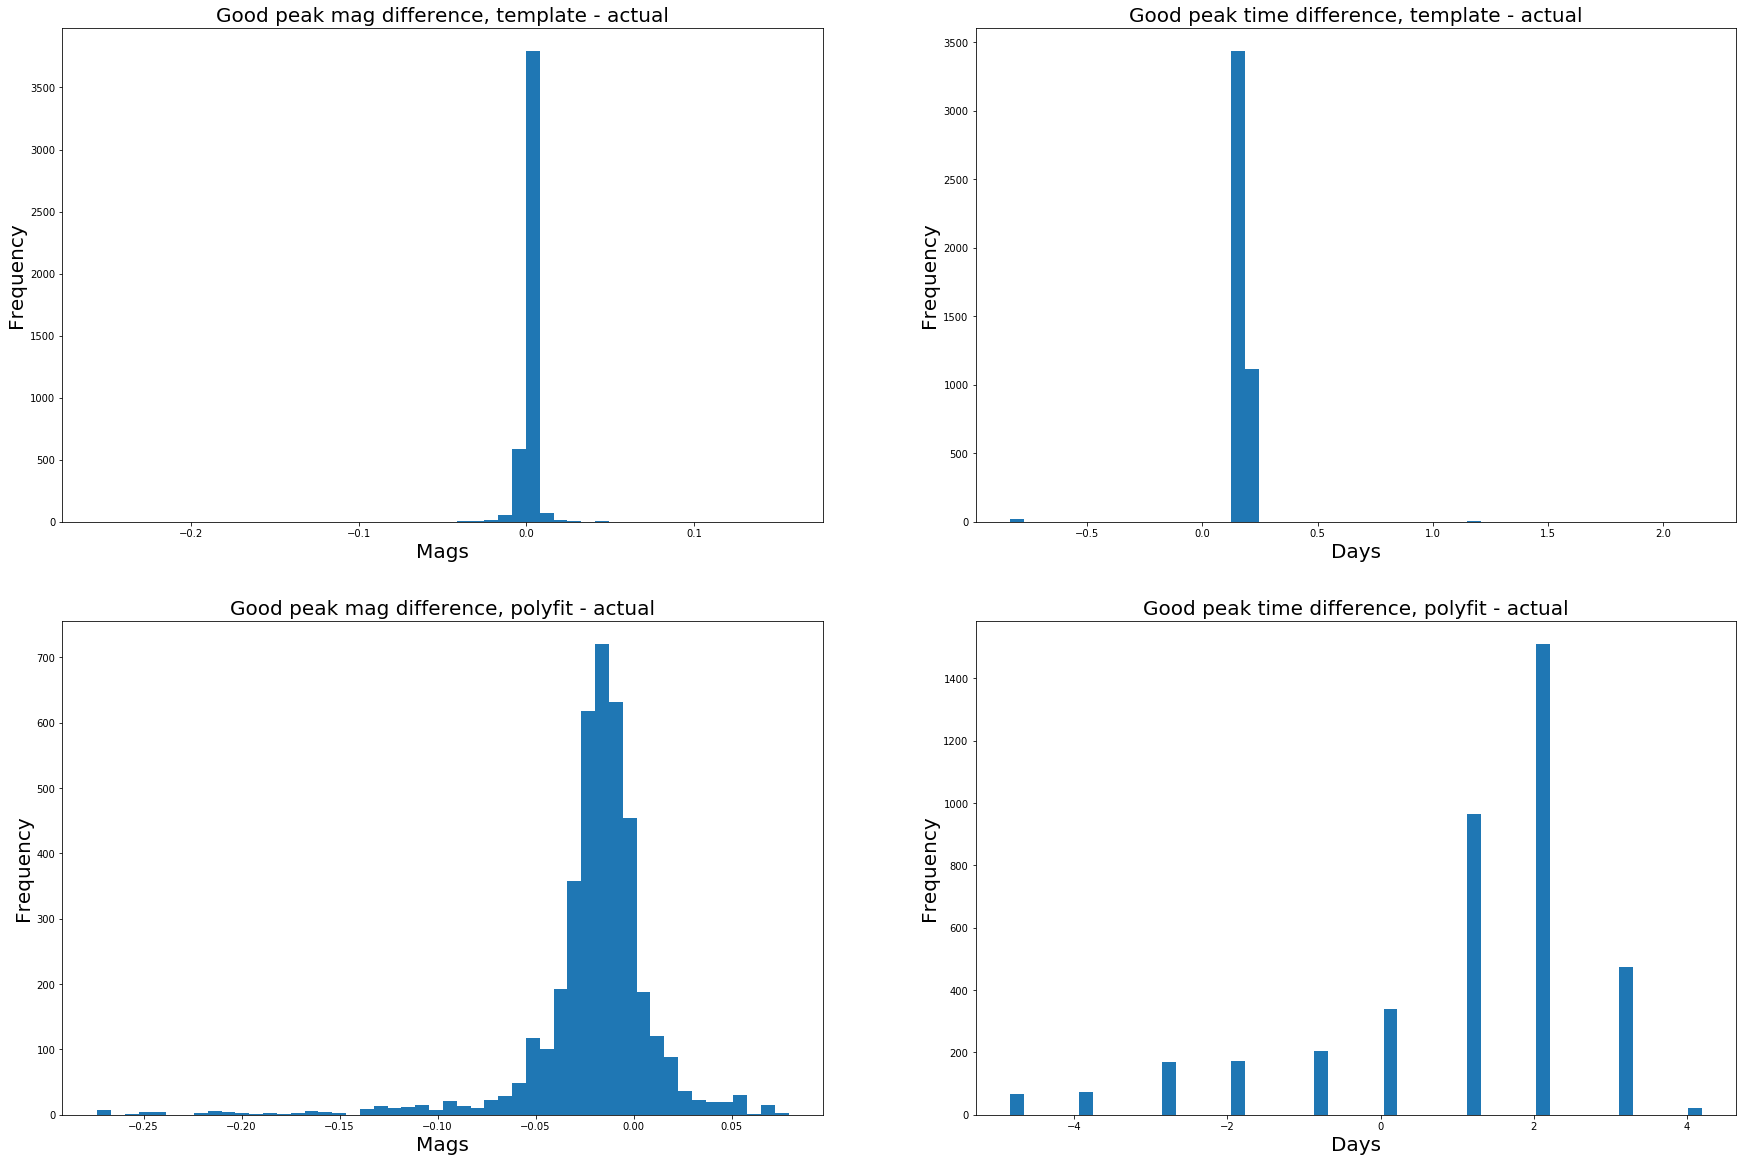

In [76]:
print detected+undetected
print peak+no_peak
for f in ['g', 'r', 'i', 'z']:
    filter_match = np.where(good_poly_diff_table['filter'] == f)
    print('average poly mag diff = %r in %s' %(np.average(good_poly_diff_table['peak_diff_mag'][filter_match]), f))
    print('average poly day diff = %r in %s' %(np.average(good_poly_diff_table['peak_diff_day'][filter_match]), f))
    
fig, ax = plt.subplots(4, 1, figsize=(30,20))
ax.hist(good_template_diff_table['peak_diff_mag'], bins = 50)
ax.set_title('Good peak mag difference, template - actual', fontsize = 20.0)
ax.set_xlabel('Mags', fontsize = 20.0)
ax.set_ylabel('Frequency', fontsize = 20.0)

ax.hist(good_template_diff_table['peak_diff_day'], bins = 50)
ax.set_title('Good peak time difference, template - actual', fontsize = 20.0)
ax.set_xlabel('Days', fontsize = 20.0)
ax.set_ylabel('Frequency', fontsize = 20.0)

ax.hist(good_poly_diff_table['peak_diff_mag'], bins = 50)
ax.set_title('Good peak mag difference, polyfit - actual', fontsize = 20.0)
ax.set_xlabel('Mags', fontsize = 20.0)
ax.set_ylabel('Frequency', fontsize = 20.0)

ax.hist(good_poly_diff_table['peak_diff_day'], bins = 50)
ax.set_title('Good peak time difference, polyfit - actual', fontsize = 20.0)
ax.set_xlabel('Days', fontsize = 20.0)
ax.set_ylabel('Frequency', fontsize = 20.0)

'''ax[0,0].hist(good_template_diff_table['peak_diff_mag'], bins = 50)
ax[0,0].set_title('Good peak mag difference, template - actual', fontsize = 20.0)
ax[0,0].set_xlabel('Mags', fontsize = 20.0)
ax[0,0].set_ylabel('Frequency', fontsize = 20.0)

ax[0,1].hist(good_template_diff_table['peak_diff_day'], bins = 50)
ax[0,1].set_title('Good peak time difference, template - actual', fontsize = 20.0)
ax[0,1].set_xlabel('Days', fontsize = 20.0)
ax[0,1].set_ylabel('Frequency', fontsize = 20.0)

ax[1,0].hist(good_poly_diff_table['peak_diff_mag'], bins = 50)
ax[1,0].set_title('Good peak mag difference, polyfit - actual', fontsize = 20.0)
ax[1,0].set_xlabel('Mags', fontsize = 20.0)
ax[1,0].set_ylabel('Frequency', fontsize = 20.0)

ax[1,1].hist(good_poly_diff_table['peak_diff_day'], bins = 50)
ax[1,1].set_title('Good peak time difference, polyfit - actual', fontsize = 20.0)
ax[1,1].set_xlabel('Days', fontsize = 20.0)
ax[1,1].set_ylabel('Frequency', fontsize = 20.0)'''

plt.savefig('deepdrilling_histograms.pdf')

In [72]:
peak = 0.
no_peak = 0.
undetected = 0.
detected = 0.

for coord in range(len(bundle.metricValues)):
    opsim = opsimlist[coord]
    for testpeakmag in peakmag:
        for testpeakday in peaktime:
            shifted_tde_table = shift_peak(model, testpeakmag, testpeakday)
            opsim2 = opsim.copy()
            opsim2 = opsim2[opsim2['expMJD'] > shifted_tde_table['mjd'].min()]
            opsim2 = opsim2[opsim2['expMJD'] < shifted_tde_table['mjd'].max()]
            if len(opsim2) == 0:
                undetected += 4
            else:
                tde_lc = resample_lc(opsim2, shifted_tde_table)
                opsim2 = update_opsim(opsim2, tde_lc)
                opsim2 = find_error(opsim2)
                if len(opsim2) == 0:
                    undetected += 4
                else:
                    opsim2 = add_noise(opsim2)
                    survey = opsim2.copy()
                    survey = survey[survey['expMJD'] <= (60 + shifted_tde_table['mjd'].min())]
                    if len(np.unique(np.round(survey['expMJD']))) >= 4:
                        detected += 1
                        peak += 1
                    else:
                        undetected += 1
                        no_peak += 1

percent_peak = (peak/(peak+no_peak))*100
percent_detected = (detected/(detected+undetected))*100
print('peak ratio = %r' %percent_peak)
print('detected ratio = %r' %percent_detected)

peak ratio = 54.04428140966855
detected ratio = 39.534868862409354


In [45]:
undetected = 0.
detected = 0.

for f in ['g', 'r', 'i', 'z']:
    bad = 0.
    good = 0.
    for coord in range(len(bundle.metricValues)):
        opsim = opsimlist[coord]
        for testpeakmag in peakmag:
            for testpeakday in peaktime:
                shifted_tde_table = shift_peak(model, testpeakmag, testpeakday)
                opsim2 = opsim.copy()
                opsim2 = opsim2[opsim2['expMJD'] > shifted_tde_table['mjd'].min()]
                opsim2 = opsim2[opsim2['expMJD'] < shifted_tde_table['mjd'].max()]
                if len(opsim2) == 0:
                    undetected += 1
                else:
                    tde_lc = resample_lc(opsim2, shifted_tde_table)
                    opsim2 = update_opsim(opsim2, tde_lc)
                    opsim2 = find_error(opsim2)
                    if len(opsim2) == 0:
                        undetected += 1
                    else:
                        opsim2 = add_noise(opsim2)
                        ra = np.degrees(round(opsim2['fieldRA'][0], 5))
                        dec = np.degrees(round(opsim2['fieldDec'][0], 5))
                        survey = opsim2.copy()
                        survey = survey[survey['expMJD'] <= (60 + shifted_tde_table['mjd'].min())]
                        filter_match = np.where(survey['filter'] == f)
                        survey2 = survey[filter_match]
                        if len(np.unique(np.round(survey2['expMJD']))) >= 4:
                            good += 1
                            detected += 1
                        else:
                            bad += 1
                            undetected += 1
                            filter_per = (good/(good + bad))*100
    print(f, filter_per)

print('undetected = %r' %undetected)

('g', 0.0)
('r', 7.3262581307771315)
('i', 7.086614173228346)
('z', 7.976720301266689)
undetected = 5264.0


In [35]:
def make_template_3d(time, time_shift, mag_shift):
    new_model = model.copy()
    new_model['mjd'] += time_shift
    new_model['mag'] += mag_shift
    template = np.zeros(time.shape)
    for i,f in enumerate(['g', 'r', 'i', 'z']):
        template[i][time[i] > 0] = np.interp(time[i][time[i] > 0], new_model['mjd'][new_model['filter'] == f], 
                                             new_model['mag'][new_model['filter'] == f])
    return template

In [44]:
def resample_lc_3d(opsim, model, time_shift, mag_shift):
    new_model = model.copy()
    new_model['mjd'] += time_shift
    new_model['mag'] += mag_shift
    maxlength = np.max([sum(opsim['filter'] == f) for f in ['g', 'r', 'i', 'z']])
    resampled_mjd = np.zeros((4, maxlength))
    resampled_mag = np.zeros((4, maxlength))
    resampled_sig = np.zeros((4, maxlength)) + 1000
    for i,f in enumerate(['g', 'r', 'i', 'z']):
        filter_match = opsim['filter'] == f
        n_samples_in_filter = filter_match.sum()
        model_filter_match = new_model['filter'] == f
        mjds =  opsim['expMJD'][filter_match]
        mags = np.interp(mjds, new_model[model_filter_match]['mjd'],
                         new_model[model_filter_match]['mag'], left=99, right=99)
        # Trim off visits where the template doesn't exist
        detections = mags < 30
        mags = mags[detections]
        mjds = mjds[detections]
        five_sigma = opsim['fiveSigmaDepth'][filter_match][detections]
        
        snr = 5*(10**((-0.4)*(mags - five_sigma)))
        mag_err = 2.5/(snr*np.log(10))
        
        good_detections = mag_err < 0.3
        n_good_detections = good_detections.sum()
        resampled_mjd[i][:n_good_detections] = mjds[good_detections]
        resampled_sig[i][:n_good_detections] = mag_err[good_detections]
        resampled_mag[i][:n_good_detections] = np.random.normal(mags[good_detections], mag_err[good_detections])
    
    return resampled_mjd, resampled_mag, resampled_sig


In [37]:
def lnlike(theta, x, y, yerr):
    mjd, mag = theta
    m = make_template_3d(x, mjd, mag)
    inv_sigma2 = 1.0 /(yerr**2)
    return -0.5*(np.sum((y-m)**2*inv_sigma2 - np.log(inv_sigma2)))

import scipy.optimize as op
import emcee
import corner
nll = lambda *args: -lnlike(*args)

In [50]:
def lnprior(theta):
    mjd, mag = theta
    if 59800 < mjd < 60350 and 16.0 < mag < 28.0:
        return 0.0
    return -np.inf

In [39]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [51]:
# Setup input variables needed, and run in order of function introduction
peakmag = np.arange(18, 20, 1)
peaktime = np.arange(59945.25, 60250, 150)
colors = {'g':'green','r':'red','i':'blue','z':'purple'}
opsimlist = survey_setup(bundle)
asciifile = 'G14_model_PS1-10jh.ascii'
model = tde_model(asciifile)
#tde_table = tde_raw('PS1-10jh.json')
inputpeak = find_peak(model)
#curvefit_full_lightcurve(tde_lc_all)

[ 99.          99.          99.          18.24264866  18.24220302
  18.21309966  18.21248443  20.35925535  20.35938306  99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

[ 99.          99.          99.          99.          99.          99.          99.
  99.          99.          18.75594053  18.75647536  19.11629537
  19.11681039  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

[ 99.          99.          99.          99.          99.          99.          99.
  19.32016089  19.3195765   99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.      

[ 99.          99.          99.          99.          19.75722055
  19.75751233  20.36062497  20.36074784  99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

[ 99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          21.79990682  21.79493936  99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.      

[ 99.          99.          99.          99.          99.          99.
  19.3134955   19.31287871  19.95663648  19.95712915  21.04657329
  21.04681878  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.     

[ 99.          99.          99.          99.          99.          20.16946814
  20.16963747  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          9

[ 99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          21.81463814  21.81111306  99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.      

[ 99.          99.          99.          99.          99.          20.92429197
  20.92216337  19.36725151  19.36768602  20.50454728  21.04584525
  21.04601946  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          

[ 99.          99.          99.          99.          19.75719909
  19.7574682   20.16845588  20.16859738  99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

[ 99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.]
[ 99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99. 

[ 99.          99.          99.          99.          99.          99.
  20.93701623  20.93523751  19.95671112  19.95717944  99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.

[ 99.          99.          99.          99.          99.          20.22461136
  20.22312236  19.02992439  19.03024697  19.45313275  99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          9

[ 99.          20.17448602  20.17480515  20.1994092   20.19988026
  21.14655191  21.1466583   99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

[ 99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          21.1386556   21.13889475
  21.34399777  21.34411508  99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

[ 99.          99.          99.          99.          99.          99.
  19.06277793  19.0631744   20.03682776  20.03700099  99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.

[ 99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.
  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.  99.]
[ 99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          20.4815428   20.48035671
  19.28832037  19.28820607  99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.

[ 99.          99.          99.          99.          99.          99.          99.
  99.          23.00165814  22.99785342  19.14347237  19.14390417  99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.      

[ 99.          99.          99.          99.          99.          99.          99.
  19.77314582  19.77332176  99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.      

[ 99.          99.          99.          99.          99.          19.11200697
  19.11228561  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          9

[ 99.          99.          99.          99.          99.          99.          99.
  99.          99.          19.1435506   19.14396597  19.7018605
  19.70247324  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.      

[ 99.          99.          99.          99.          99.          99.
  18.55857146  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.

[ 99.          99.          99.          99.          99.          19.1133032
  21.31866183  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99

[ 99.          99.          99.          99.          99.          99.          99.
  19.14361029  19.14403961  19.14528955  19.14566246  20.11536141
  20.11578365  99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.          99.          99.          99.          99.          99.          99.
  99.     

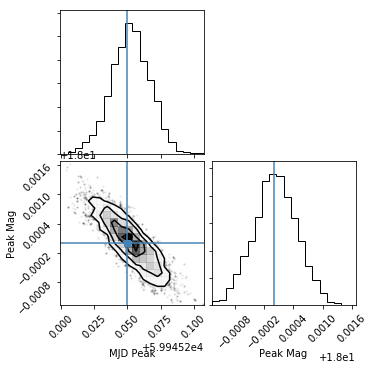

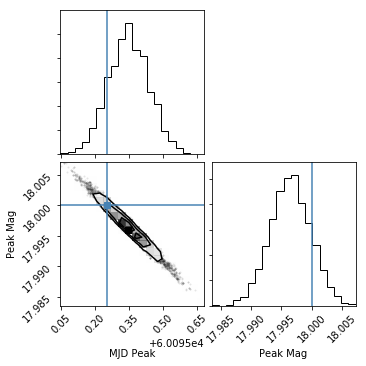

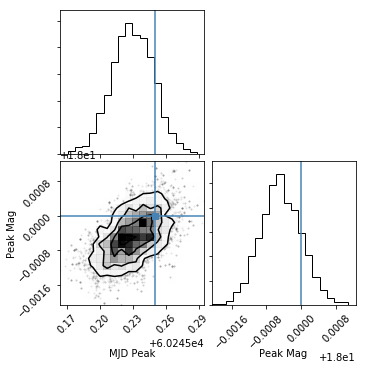

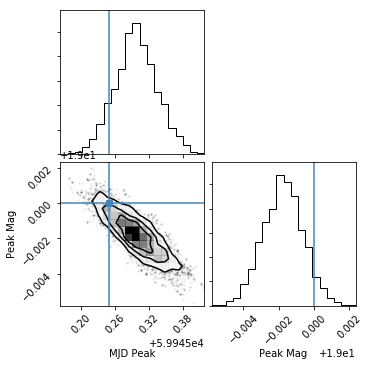

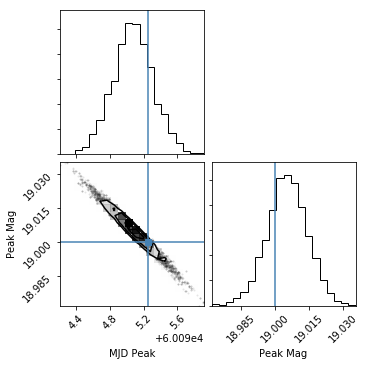

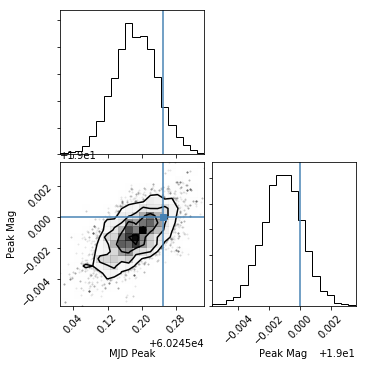

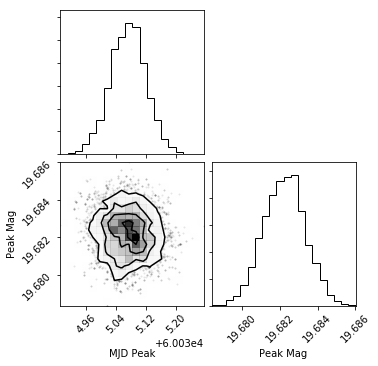

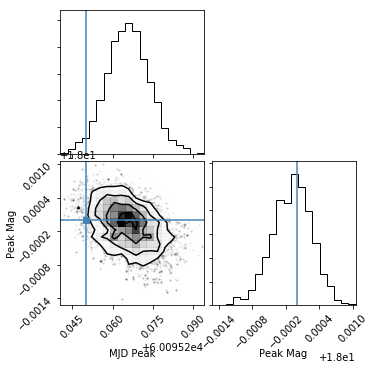

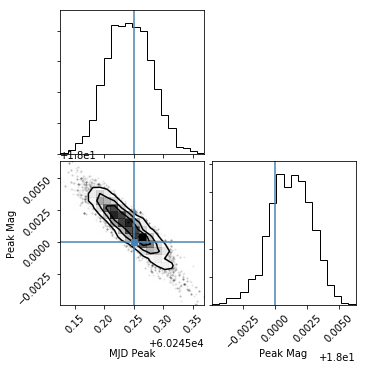

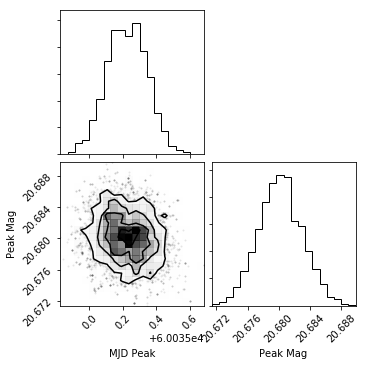

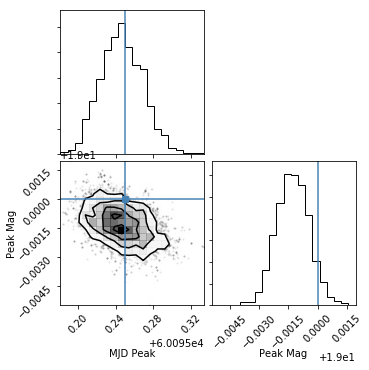

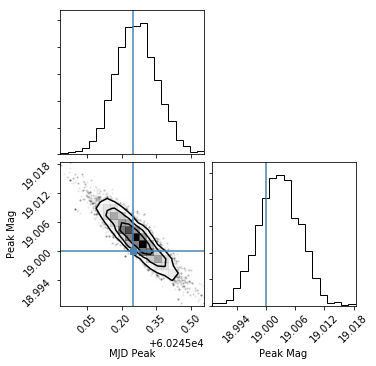

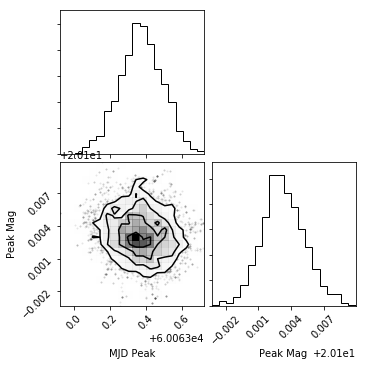

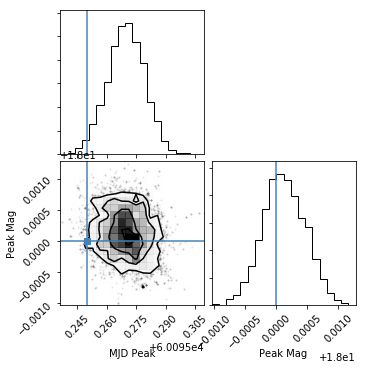

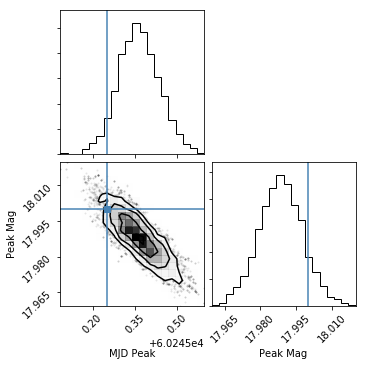

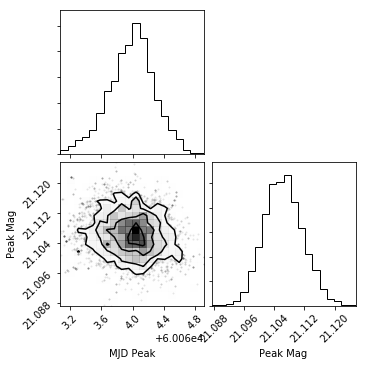

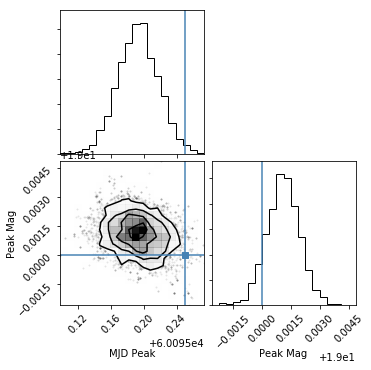

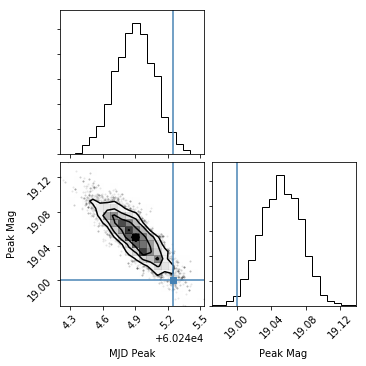

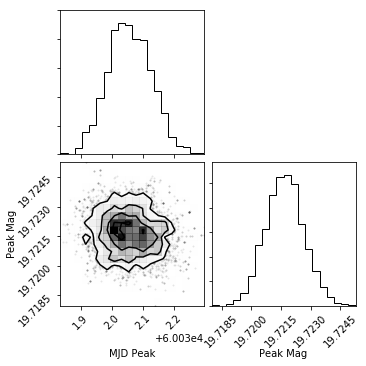

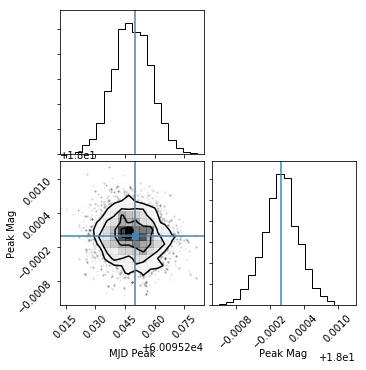

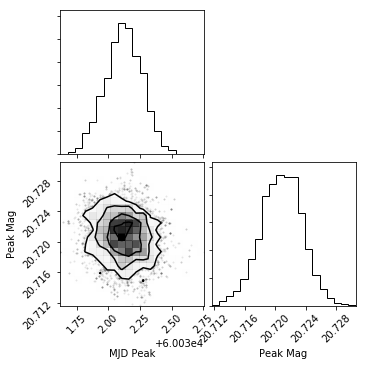

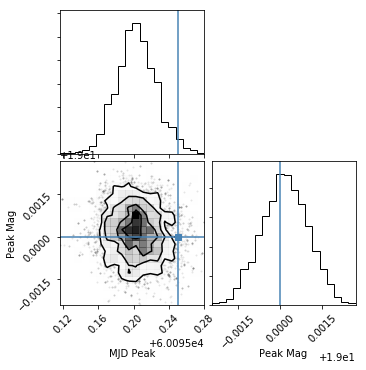

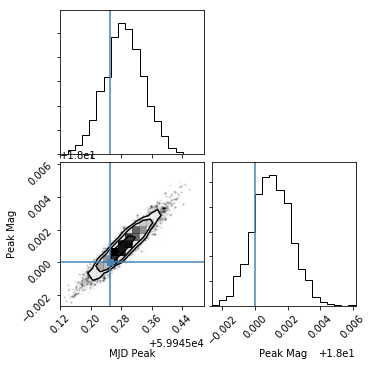

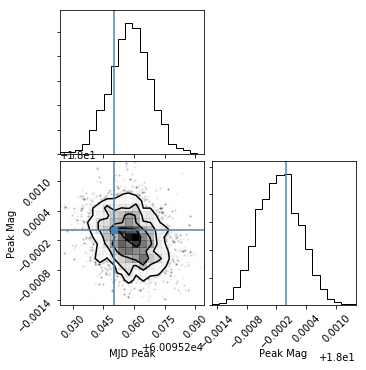

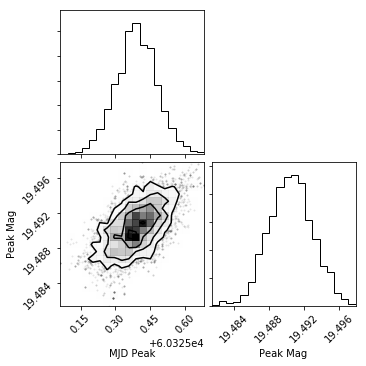

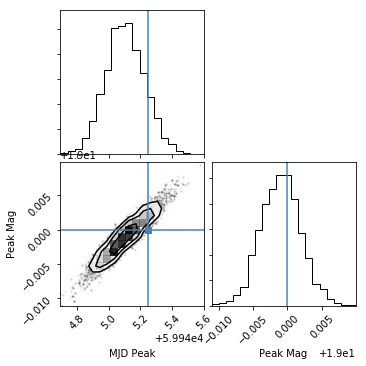

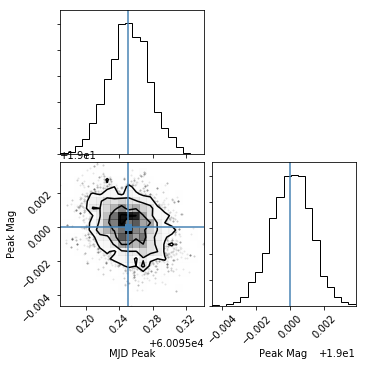

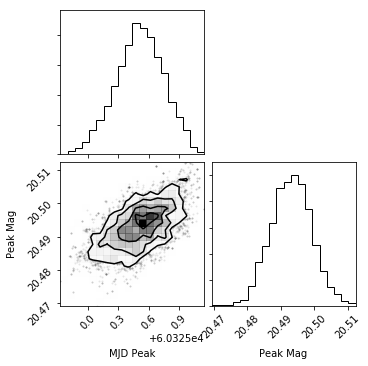

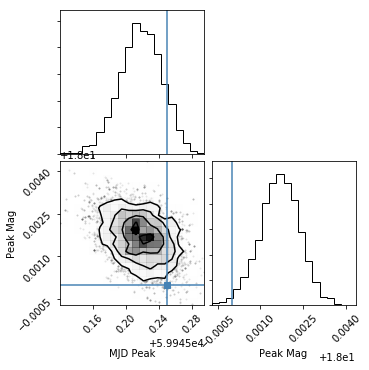

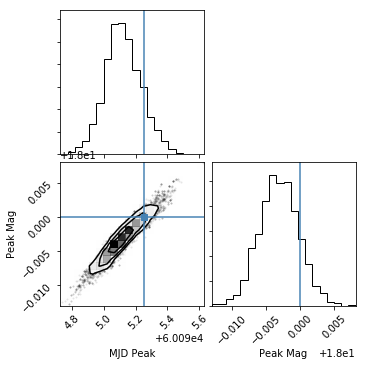

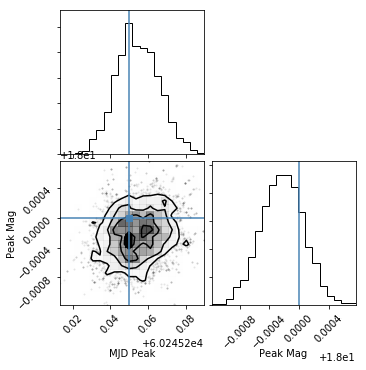

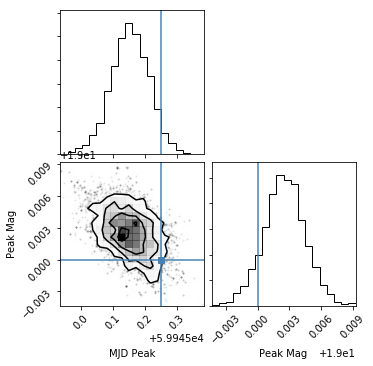

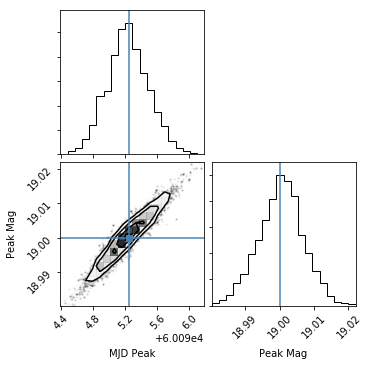

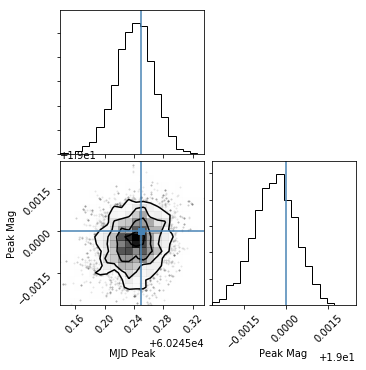

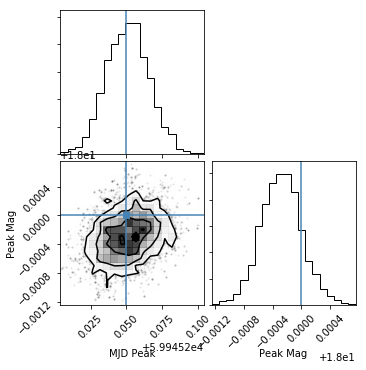

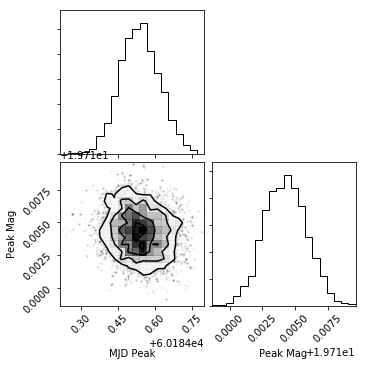

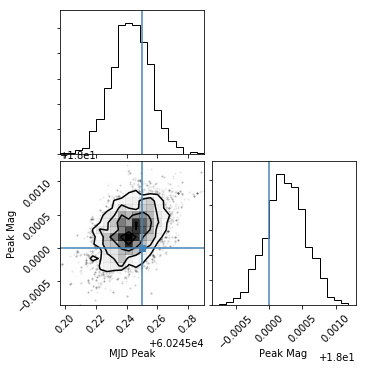

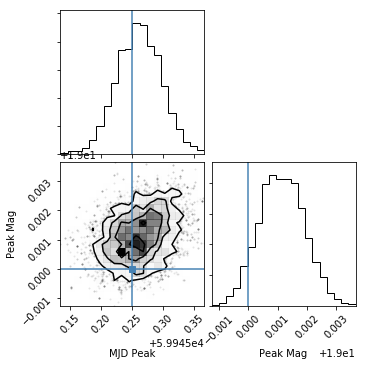

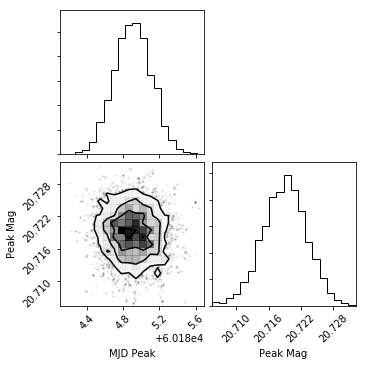

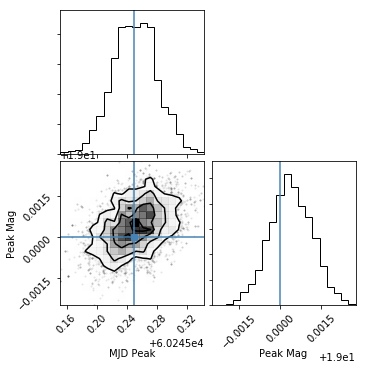

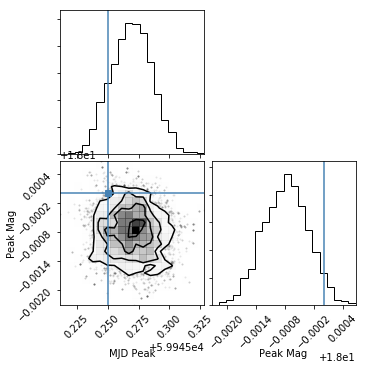

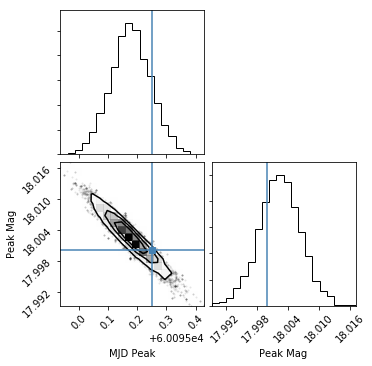

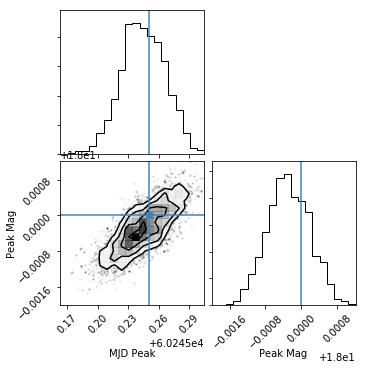

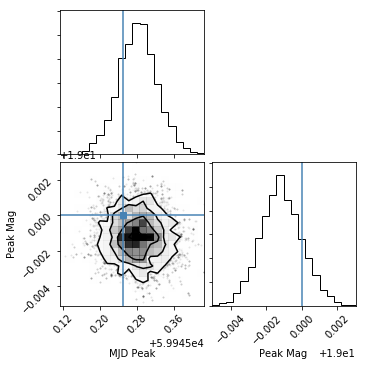

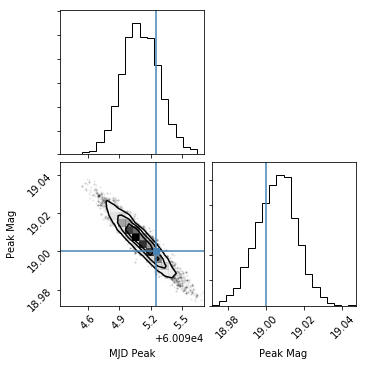

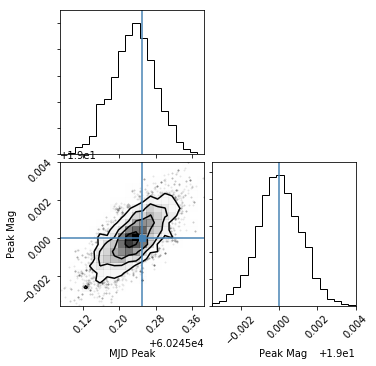

In [52]:
for coord in range(len(bundle.metricValues)):
    opsim = opsimlist[coord]
    for testpeakmag in peakmag:
        for testpeakday in peaktime:
            mjds, mags, magerrs = resample_lc_3d(opsim, model, testpeakday, testpeakmag)
            detections = mjds > 0
            try:
                max_mjd = mjds[detections][np.argmin(mags[detections])]
                max_mag = np.min(mags[detections])
                result = op.minimize(nll, [max_mjd, max_mag], args=(mjds, mags, magerrs))
                ndim, nwalkers = 2, 16
                pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
                sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mjds, mags, magerrs))
                sampler.run_mcmc(pos, 500)
                samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
                fig = corner.corner(samples, labels=["MJD Peak", "Peak Mag"], truths=[testpeakday, testpeakmag])
            except ValueError:
                print('No data!')

In [23]:
'''import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [max_mjd, max_mag], args=(mjds, mags, magerrs))'''

'import scipy.optimize as op\nnll = lambda *args: -lnlike(*args)\nresult = op.minimize(nll, [max_mjd, max_mag], args=(mjds, mags, magerrs))'

In [120]:
'''ndim, nwalkers = 2, 16
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
print(pos)'''

[array([  6.02494000e+04,   2.00181038e+01]), array([  6.02494002e+04,   2.00181602e+01]), array([  6.02494001e+04,   2.00180742e+01]), array([  6.02494000e+04,   2.00181748e+01]), array([  6.02494002e+04,   2.00181311e+01]), array([  6.02494001e+04,   2.00179905e+01]), array([  6.02493999e+04,   2.00180952e+01]), array([  6.02494001e+04,   2.00179562e+01]), array([  6.02494001e+04,   2.00180719e+01]), array([  6.02494002e+04,   2.00180499e+01]), array([  6.02494001e+04,   2.00181153e+01]), array([  6.02494001e+04,   2.00180290e+01]), array([  6.02493999e+04,   2.00179176e+01]), array([  6.02493998e+04,   2.00181198e+01]), array([  6.02493999e+04,   2.00182234e+01]), array([  6.02494001e+04,   2.00180311e+01])]


In [30]:
'''import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mjds, mags, magerrs))'''

'import emcee\nsampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mjds, mags, magerrs))'

In [29]:
'''sampler.run_mcmc(pos, 500)'''

'sampler.run_mcmc(pos, 500)'

In [32]:
'''samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
plt.plot(samples[:, 1])'''

'samples = sampler.chain[:, 50:, :].reshape((-1, ndim))\nplt.plot(samples[:, 1])'

In [33]:
'''import corner
fig = corner.corner(samples, labels=["MJD Peak", "Peak Mag"],
                      truths=[60250, 20])
'''

'import corner\nfig = corner.corner(samples, labels=["MJD Peak", "Peak Mag"],\n                      truths=[60250, 20])\n'